# Generating synthetic datasets

## Imports

In [16]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
import random

## Propagation data generation

In [1]:
def generate_spike_data_patterned(total_duration_ms, num_propagations, rows, cols):
    segment_duration_ms = total_duration_ms / num_propagations
    N_channels = rows * cols
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    train_patterned = [[] for _ in range(N_channels)]

    for propagation in range(num_propagations):
        segment_start = propagation * segment_duration_ms
        row_duration_ms = segment_duration_ms / rows

        for row in range(rows):
            row_start = segment_start + (row * row_duration_ms)
            spike_time = row_start + row_duration_ms / 2

            for col in range(cols):
                channel_index = row * cols + col
                train_patterned[channel_index].append(spike_time)

    train_patterned = [np.array(times) for times in train_patterned]
    return SpikeData(train=train_patterned, neuron_data=neuron_data)

## Helper functions

In [3]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)


## Plotting functions

In [4]:
def firing_plotter(sd):

    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []

    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    # Adjust size scaling for more variance
    min_rate, max_rate = np.min(firing_rates), np.max(firing_rates)
    sizes = ((firing_rates - min_rate) / (max_rate - min_rate) * 300) + 10  # Normalize and scale

    plt.figure(figsize=(8, 6))
    # scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    scatter = plt.scatter(neuron_x, neuron_y, s=sizes/1.5, c=firing_rates, alpha=0.6, cmap=cm)
    plt.title("Neuron Firing Rates")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.show()

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()


## Data visualizations

In [9]:
total_duration_ms = 60 * 1000  # 60 seconds in milliseconds
num_propagations = 5
rows, cols = 16, 16
N_channels = rows * cols
segment_duration_ms = total_duration_ms / num_propagations  # Duration of each propagation segment

positions = [(x, y) for x in range(rows) for y in range(cols)]

# Initialize neuron_data with positions
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

# Initialize train with empty lists for each channel
train_patterned = [[] for _ in range(N_channels)]

# Generate spike times for the specified pattern
for propagation in range(num_propagations):
    segment_start = propagation * segment_duration_ms
    row_duration_ms = segment_duration_ms / rows  # Time allocated for each row to fire

    for row in range(rows):
        row_start = segment_start + (row * row_duration_ms)
        # Assign a single spike time in the middle of each row's allocated duration
        spike_time = row_start + row_duration_ms / 2

        for col in range(cols):
            channel_index = row * cols + col
            train_patterned[channel_index].append(spike_time)

# Convert lists to numpy arrays for consistency with previous dataset
train_patterned = [np.array(times) for times in train_patterned]

# Update the SpikeData object for the new dataset
spike_data_patterned = SpikeData(train=train_patterned, neuron_data=neuron_data)

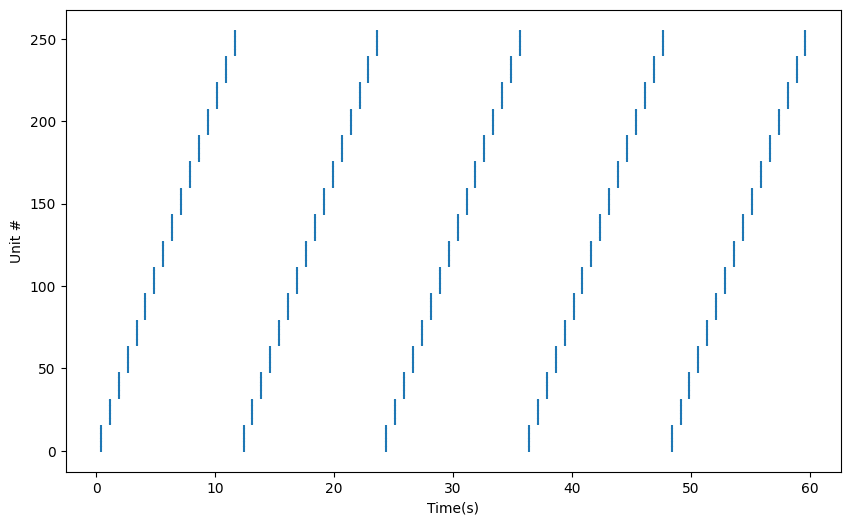

In [10]:
plot_raster(spike_data_patterned)

In [11]:
# Parameters for the simulation
total_duration_ms = 60 * 1000  # 60 seconds in milliseconds
num_propagations = 5
rows, cols = 16, 16
N_channels = rows * cols
overlap_duration_ms = 100  # Duration of overlap between rows in milliseconds
break_duration_ms = 5 * 1000  # Break duration between propagations in milliseconds

# Calculate adjusted segment and row durations
adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
segment_duration_ms = adjusted_total_duration_ms / num_propagations
row_duration_ms = segment_duration_ms / rows  # Not accounting for overlap yet

# Initialize positions and neuron_data
positions = [(x, y) for x in range(rows) for y in range(cols)]
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

# Initialize train with empty lists for each channel
train_patterned_overlap = [[] for _ in range(N_channels)]

# Generate spike times with specified overlap and breaks
for propagation in range(num_propagations):
    segment_start = propagation * (segment_duration_ms + break_duration_ms)
    for row in range(rows):
        row_start = segment_start + (row * (row_duration_ms - overlap_duration_ms))
        spike_time_start = row_start
        spike_time_end = spike_time_start + row_duration_ms + overlap_duration_ms  # Extend for overlap
        for col in range(cols):
            channel_index = row * cols + col
            spike_times = np.linspace(spike_time_start, spike_time_end, int(row_duration_ms / 10))  # Example: Generate spikes within overlap
            train_patterned_overlap[channel_index].extend(spike_times)

# Convert lists to numpy arrays
train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

# Update the SpikeData object
spike_data_patterned_overlap = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

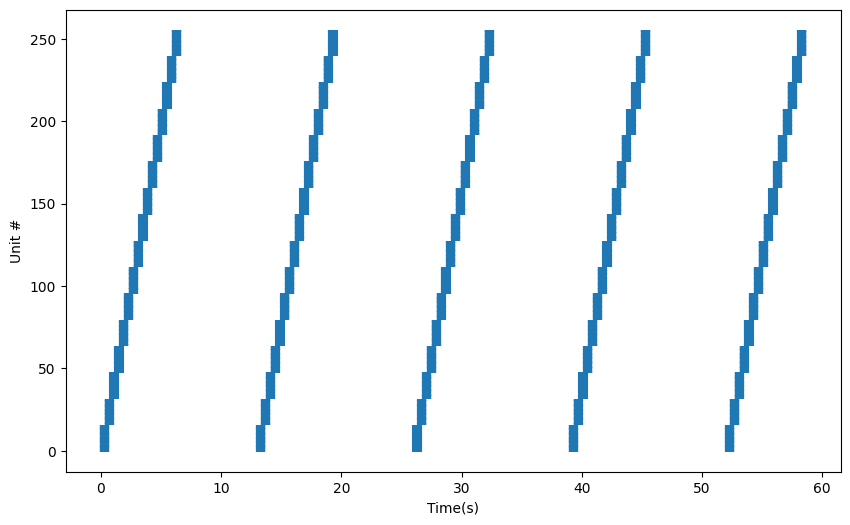

In [12]:
plot_raster(spike_data_patterned_overlap)

In [17]:
# Parameters for the simulation
total_duration_ms = 60 * 1000  # 60 seconds in milliseconds
num_propagations = 5
rows, cols = 16, 16
N_channels = rows * cols
overlap_duration_ms = 100  # Duration of overlap between rows in milliseconds
break_duration_ms = 5 * 1000  # Break duration between propagations in milliseconds

# Calculate adjusted segment and row durations
adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
segment_duration_ms = adjusted_total_duration_ms / num_propagations
row_duration_ms = segment_duration_ms / rows  # Not accounting for overlap yet

# Initialize positions and neuron_data
positions = [(x, y) for x in range(rows) for y in range(cols)]
neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

# Re-initialize train with empty lists for each channel to correct the previous mistake
train_patterned_overlap = [[] for _ in range(N_channels)]

# Generate spike times with specified overlap, breaks, and random firing within rows
for propagation in range(num_propagations):
    segment_start = propagation * (segment_duration_ms + break_duration_ms)
    
    for row in range(rows):
        row_start = segment_start + (row * (row_duration_ms - overlap_duration_ms))
        spike_time_start = row_start
        spike_time_end = spike_time_start + row_duration_ms + overlap_duration_ms  # Extend for overlap
        
        # Randomly decide which neurons in the row will fire (random proportion)
        firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))
        
        for neuron_index in firing_neurons_in_row:
            spike_times = np.linspace(spike_time_start, spike_time_end, int(row_duration_ms / 10))  # Generate spikes within overlap
            train_patterned_overlap[neuron_index].extend(spike_times)

# NOW convert lists to numpy arrays after all modifications are complete
train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

# Update the SpikeData object again with the corrected dataset
spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

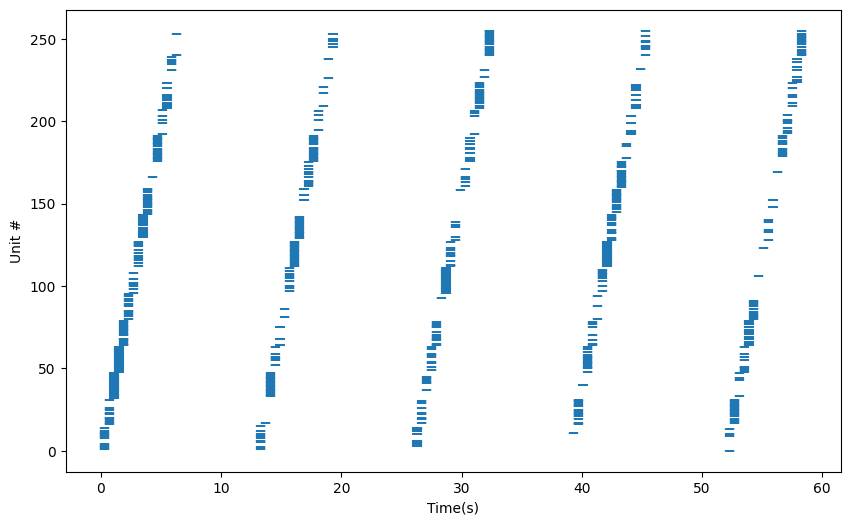

In [18]:
plot_raster(spike_data_patterned_random_firing)

In [19]:
def generate_spike_data_with_pattern(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Generate spike times with specified overlap, breaks, and random firing within rows
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
            
            # Randomly decide which neurons in the row will fire (random proportion)
            firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))
            
            for neuron_index in firing_neurons_in_row:
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
                train_patterned_overlap[neuron_index].extend(spike_times)
    
    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
    # Create the SpikeData object
    spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
    return spike_data_patterned_random_firing

In [20]:
spike_data = generate_spike_data_with_pattern(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000  # 5 seconds
)

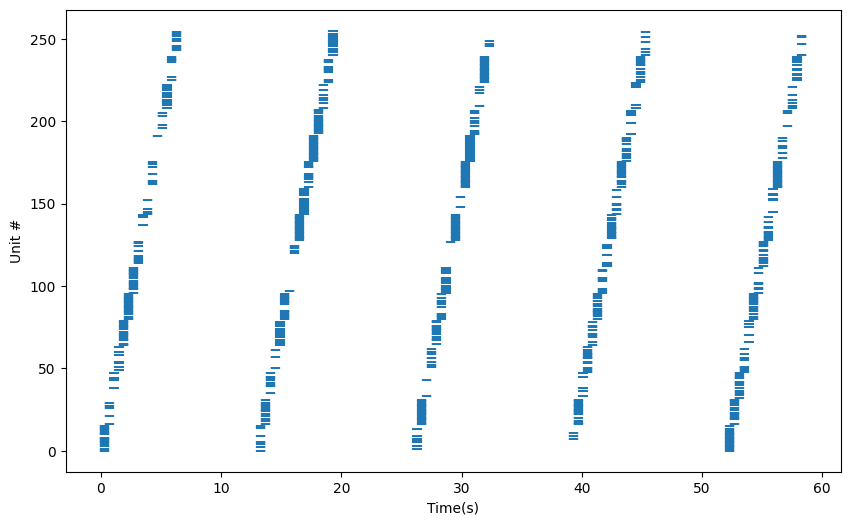

In [21]:
plot_raster(spike_data)

## Methods

### Functional Connectivity

### Spatial Activity Profiles

### Latency-vector method